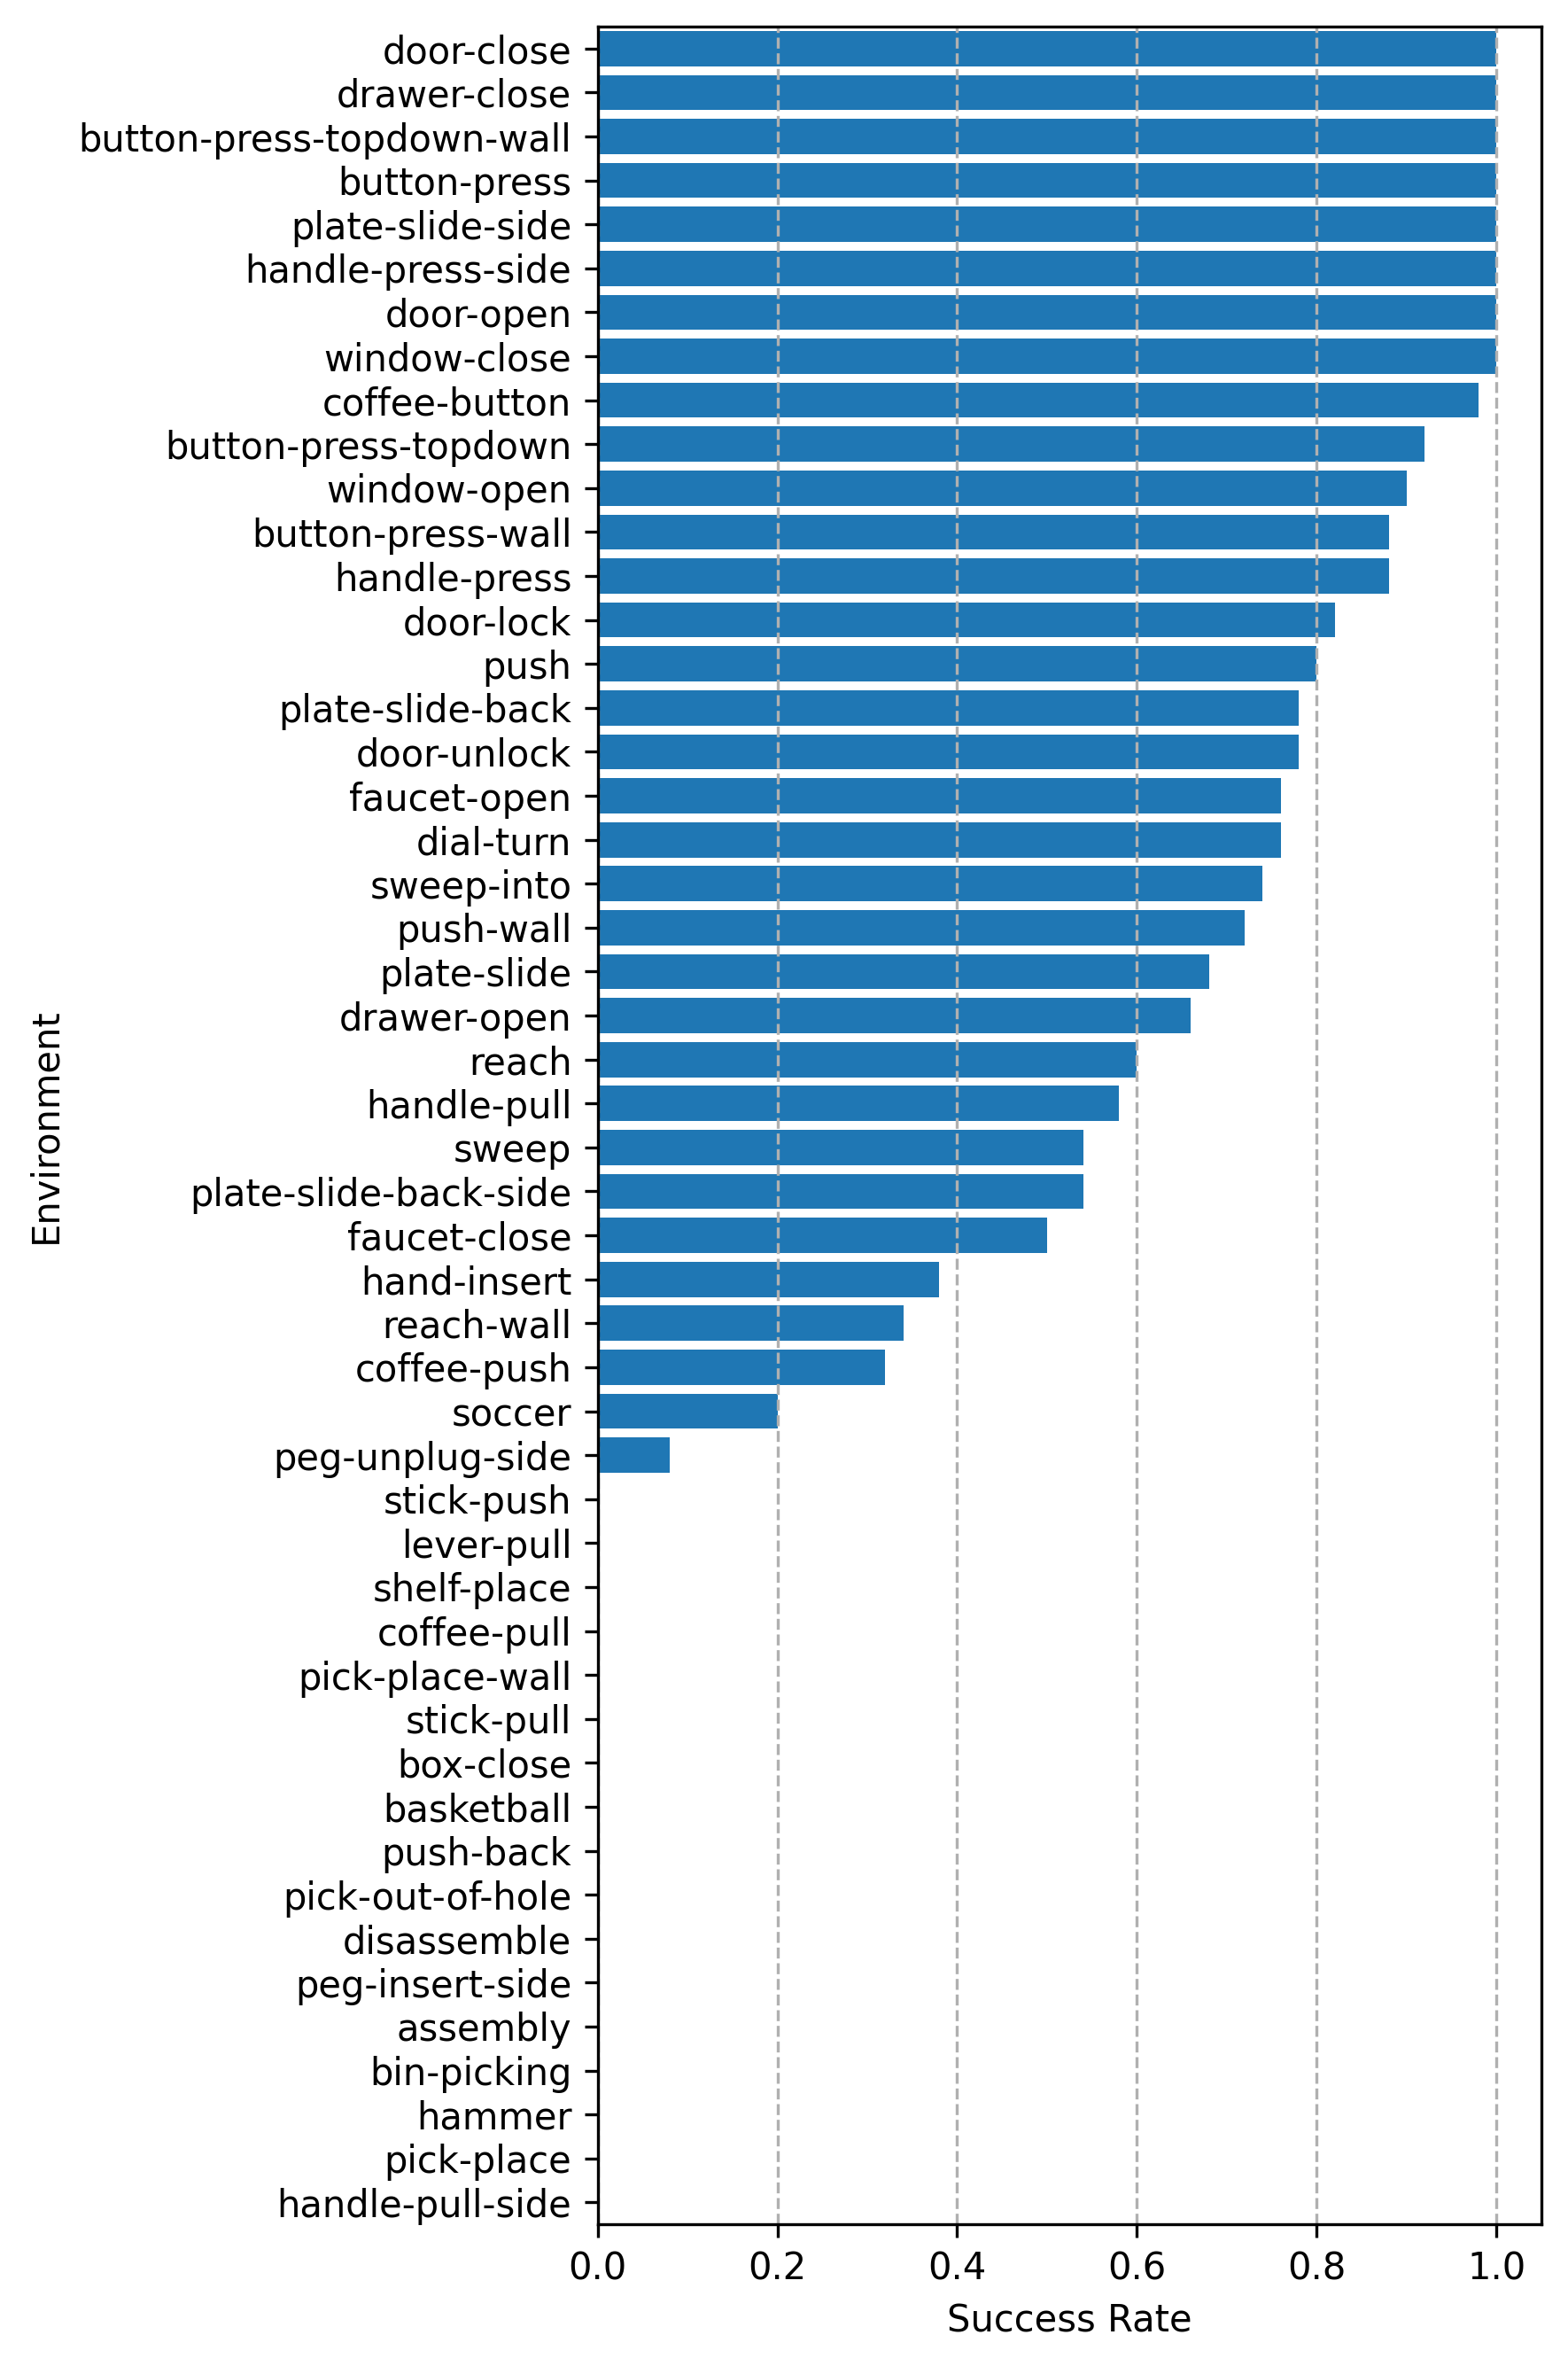

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

csv_path = "wandb_logs/mt50_smoe_e6_se0_k4_lb_seed1_data.csv"  # adjust if needed

# Load CSV
df = pd.read_csv(csv_path)

# Select columns of the form "charts/{task_name}_success_rate"
rate_cols = [
    c for c in df.columns
    if c.startswith("charts/") and c.endswith("-v3_success_rate")
]

env_names = []
last_success_rates = []

for col in rate_cols:
    # Extract task_name from "charts/{task_name}_success_rate"
    # e.g., "charts/door-open_success_rate" -> "door-open"
    inner = col[len("charts/"):]              # remove "charts/"
    task_name = inner[: -len("-v3_success_rate")]  # remove "_success_rate"

    # if task_name == "mean":
    #     continue

    # Get the column, coerce to numeric, keep NaNs for empty / non-numeric
    series = pd.to_numeric(df[col], errors="coerce")

    # Find last non-NaN value
    valid = series.dropna()
    if valid.empty:
        continue  # skip if column has no valid values

    last_value = valid.iloc[-1]

    env_names.append(task_name)
    last_success_rates.append(last_value)

# Convert to numpy arrays (optional, convenient for plotting)
env_names = np.array(env_names)
last_success_rates = np.array(last_success_rates)

# Sort by success rate if you want (optional)
order = np.argsort(last_success_rates)
env_names = env_names[order]
last_success_rates = last_success_rates[order]

# Plot horizontal bar chart
fig, ax = plt.subplots(figsize=(6, 9), dpi=300)
ax.barh(env_names, last_success_rates)
ax.set_xlabel("Success Rate")
ax.set_ylabel("Environment")
ax.set_ylim(-0.5, len(env_names) - 0.5)
ax.grid(linestyle='--', axis='x')
# plt.title("Final Success Rate per Environment")
plt.tight_layout()
plt.savefig('fig/per_task_success_rate.png')
plt.show()

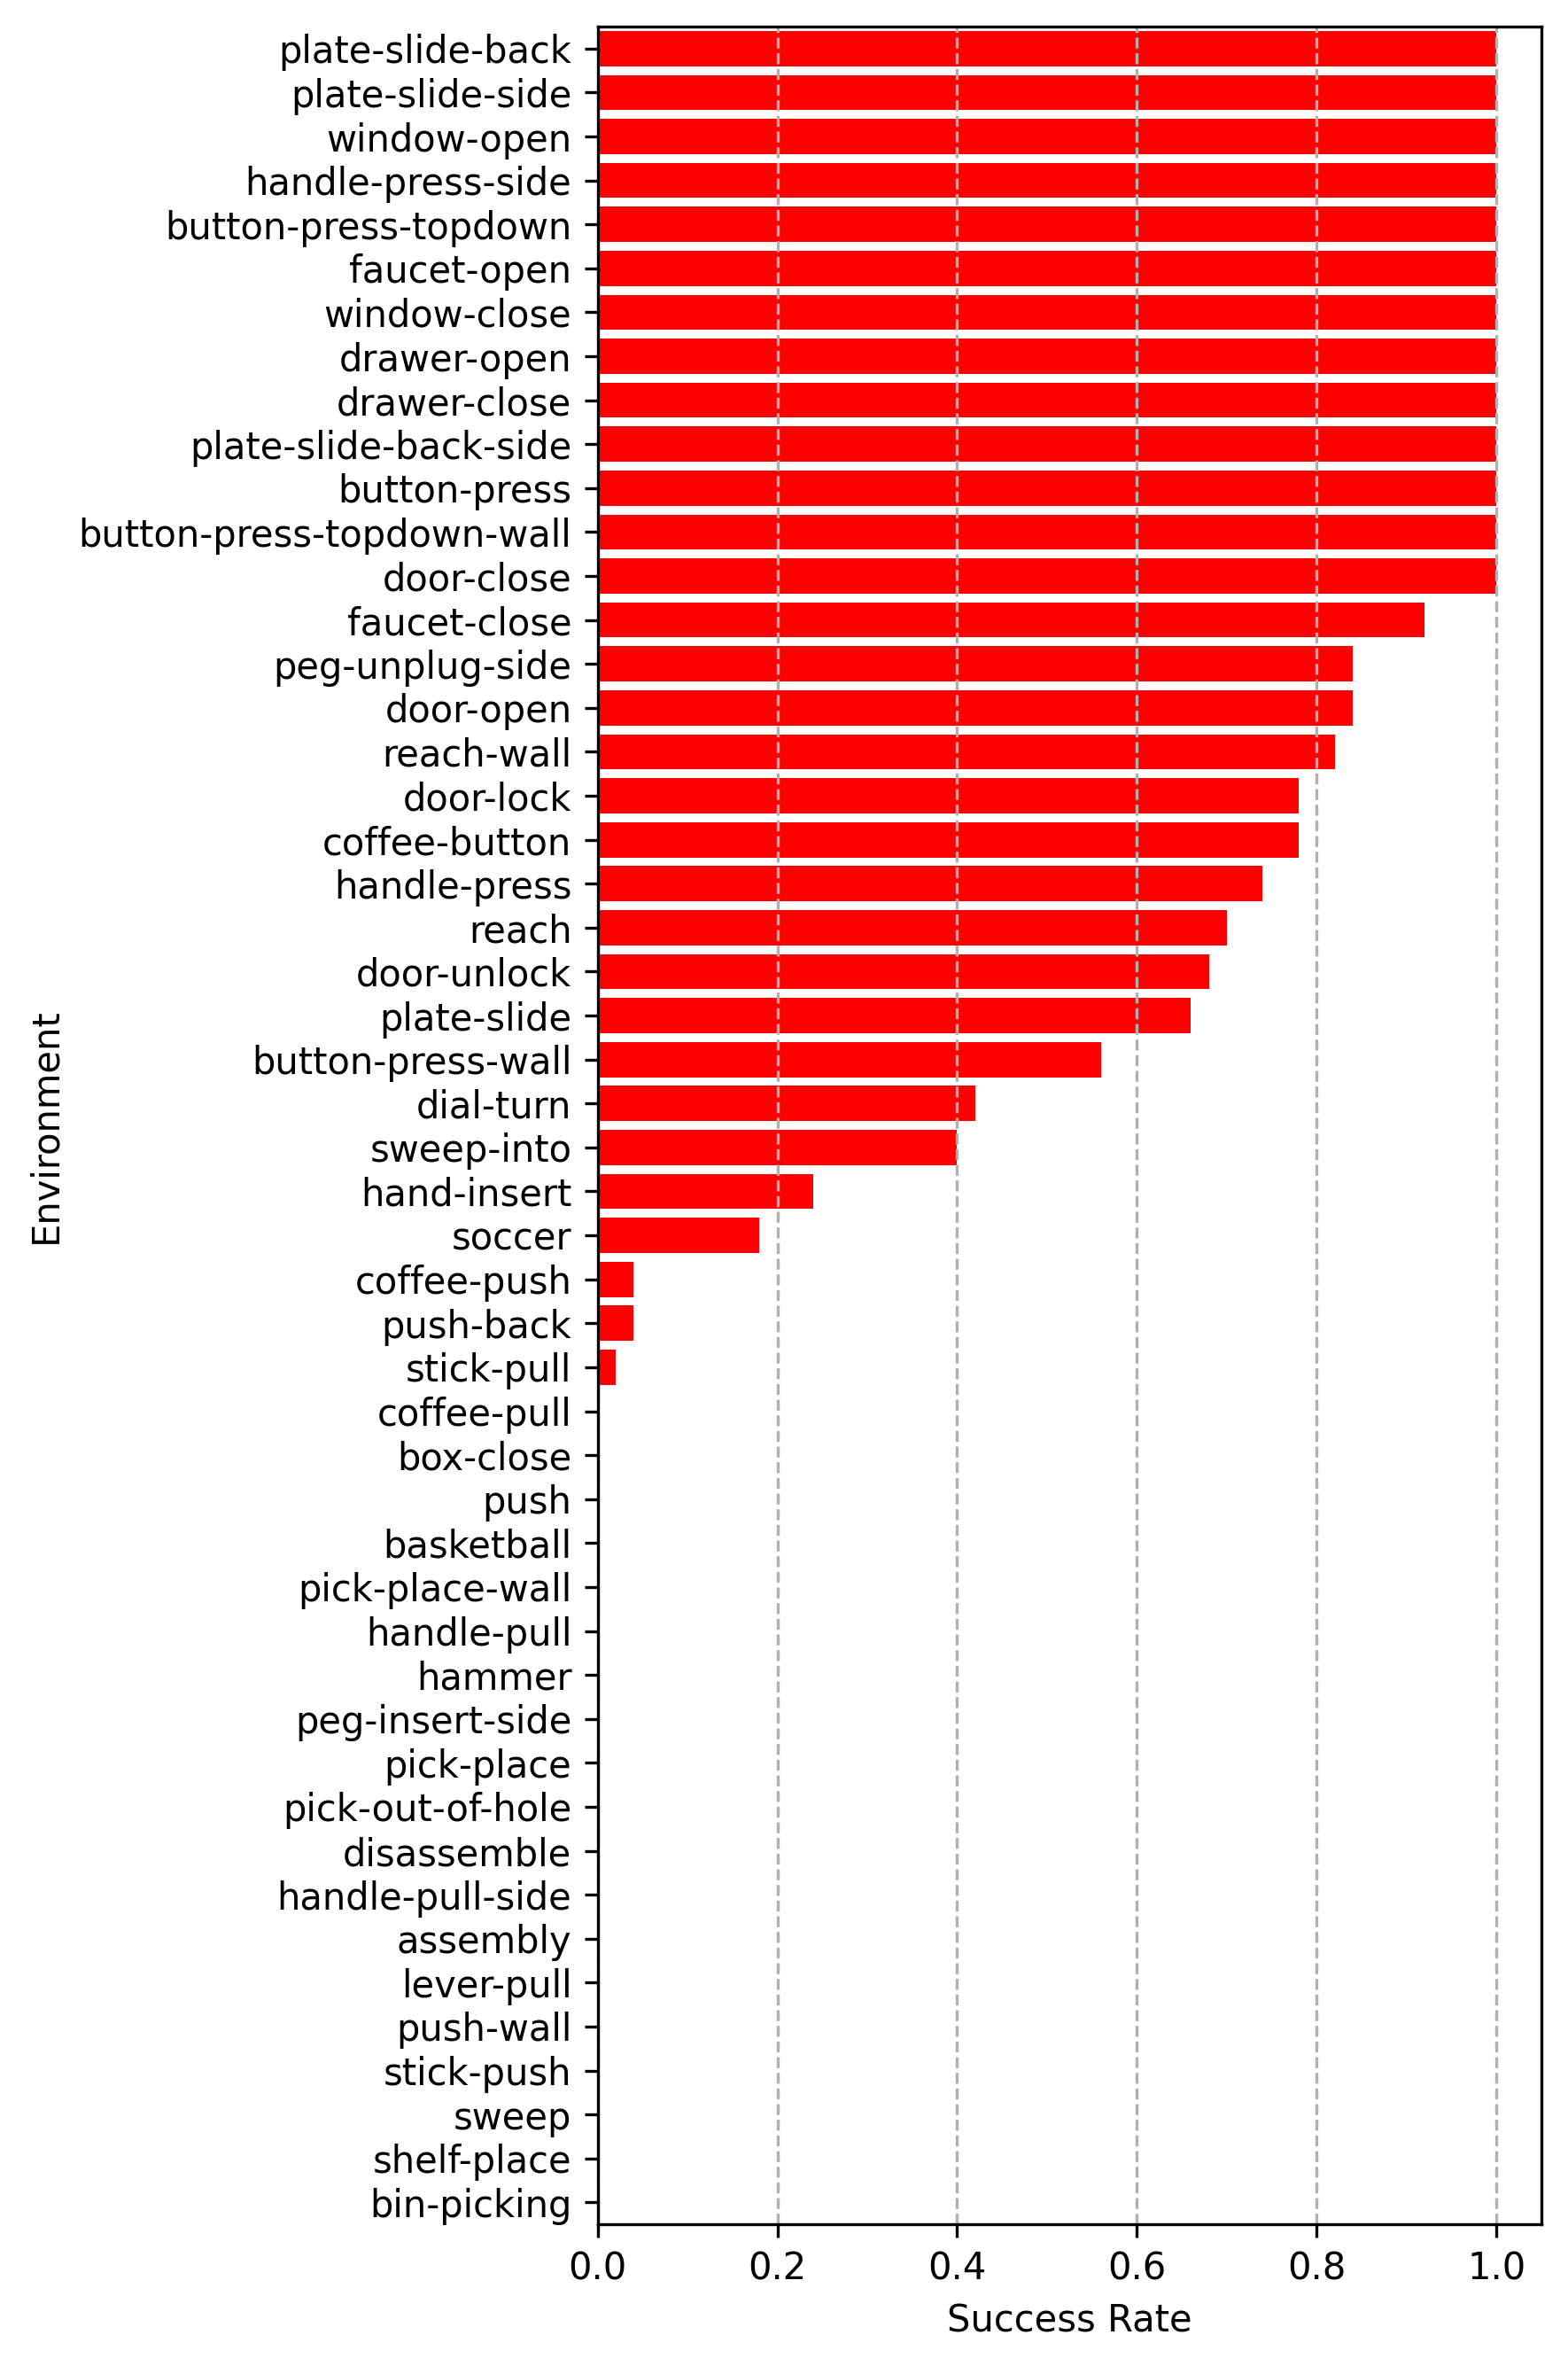

In [26]:
csv_path = "wandb_logs/mt50_pcgrad_seed1_data.csv"

# Load CSV
df = pd.read_csv(csv_path)

# Select columns of the form "charts/{task_name}_success_rate"
rate_cols = [
    c for c in df.columns
    if c.startswith("charts/") and c.endswith("-v3_success_rate")
]

env_names = []
last_success_rates = []

for col in rate_cols:
    # Extract task_name from "charts/{task_name}_success_rate"
    # e.g., "charts/door-open_success_rate" -> "door-open"
    inner = col[len("charts/"):]              # remove "charts/"
    task_name = inner[: -len("-v3_success_rate")]  # remove "_success_rate"

    # if task_name == "mean":
    #     continue

    # Get the column, coerce to numeric, keep NaNs for empty / non-numeric
    series = pd.to_numeric(df[col], errors="coerce")

    # Find last non-NaN value
    valid = series.dropna()
    if valid.empty:
        continue  # skip if column has no valid values

    last_value = valid.iloc[-1]

    env_names.append(task_name)
    last_success_rates.append(last_value)

# Convert to numpy arrays (optional, convenient for plotting)
env_names = np.array(env_names)
last_success_rates = np.array(last_success_rates)

# Sort by success rate if you want (optional)
order = np.argsort(last_success_rates)
env_names = env_names[order]
last_success_rates = last_success_rates[order]

# Plot horizontal bar chart
fig, ax = plt.subplots(figsize=(6, 9), dpi=300)
ax.barh(env_names, last_success_rates, color='red')
ax.set_xlabel("Success Rate")
ax.set_ylabel("Environment")
ax.set_ylim(-0.5, len(env_names) - 0.5)
ax.grid(linestyle='--', axis='x')
# plt.title("Final Success Rate per Environment")
plt.tight_layout()
plt.savefig('fig/per_task_success_rate_pcgrad.png')
plt.show()

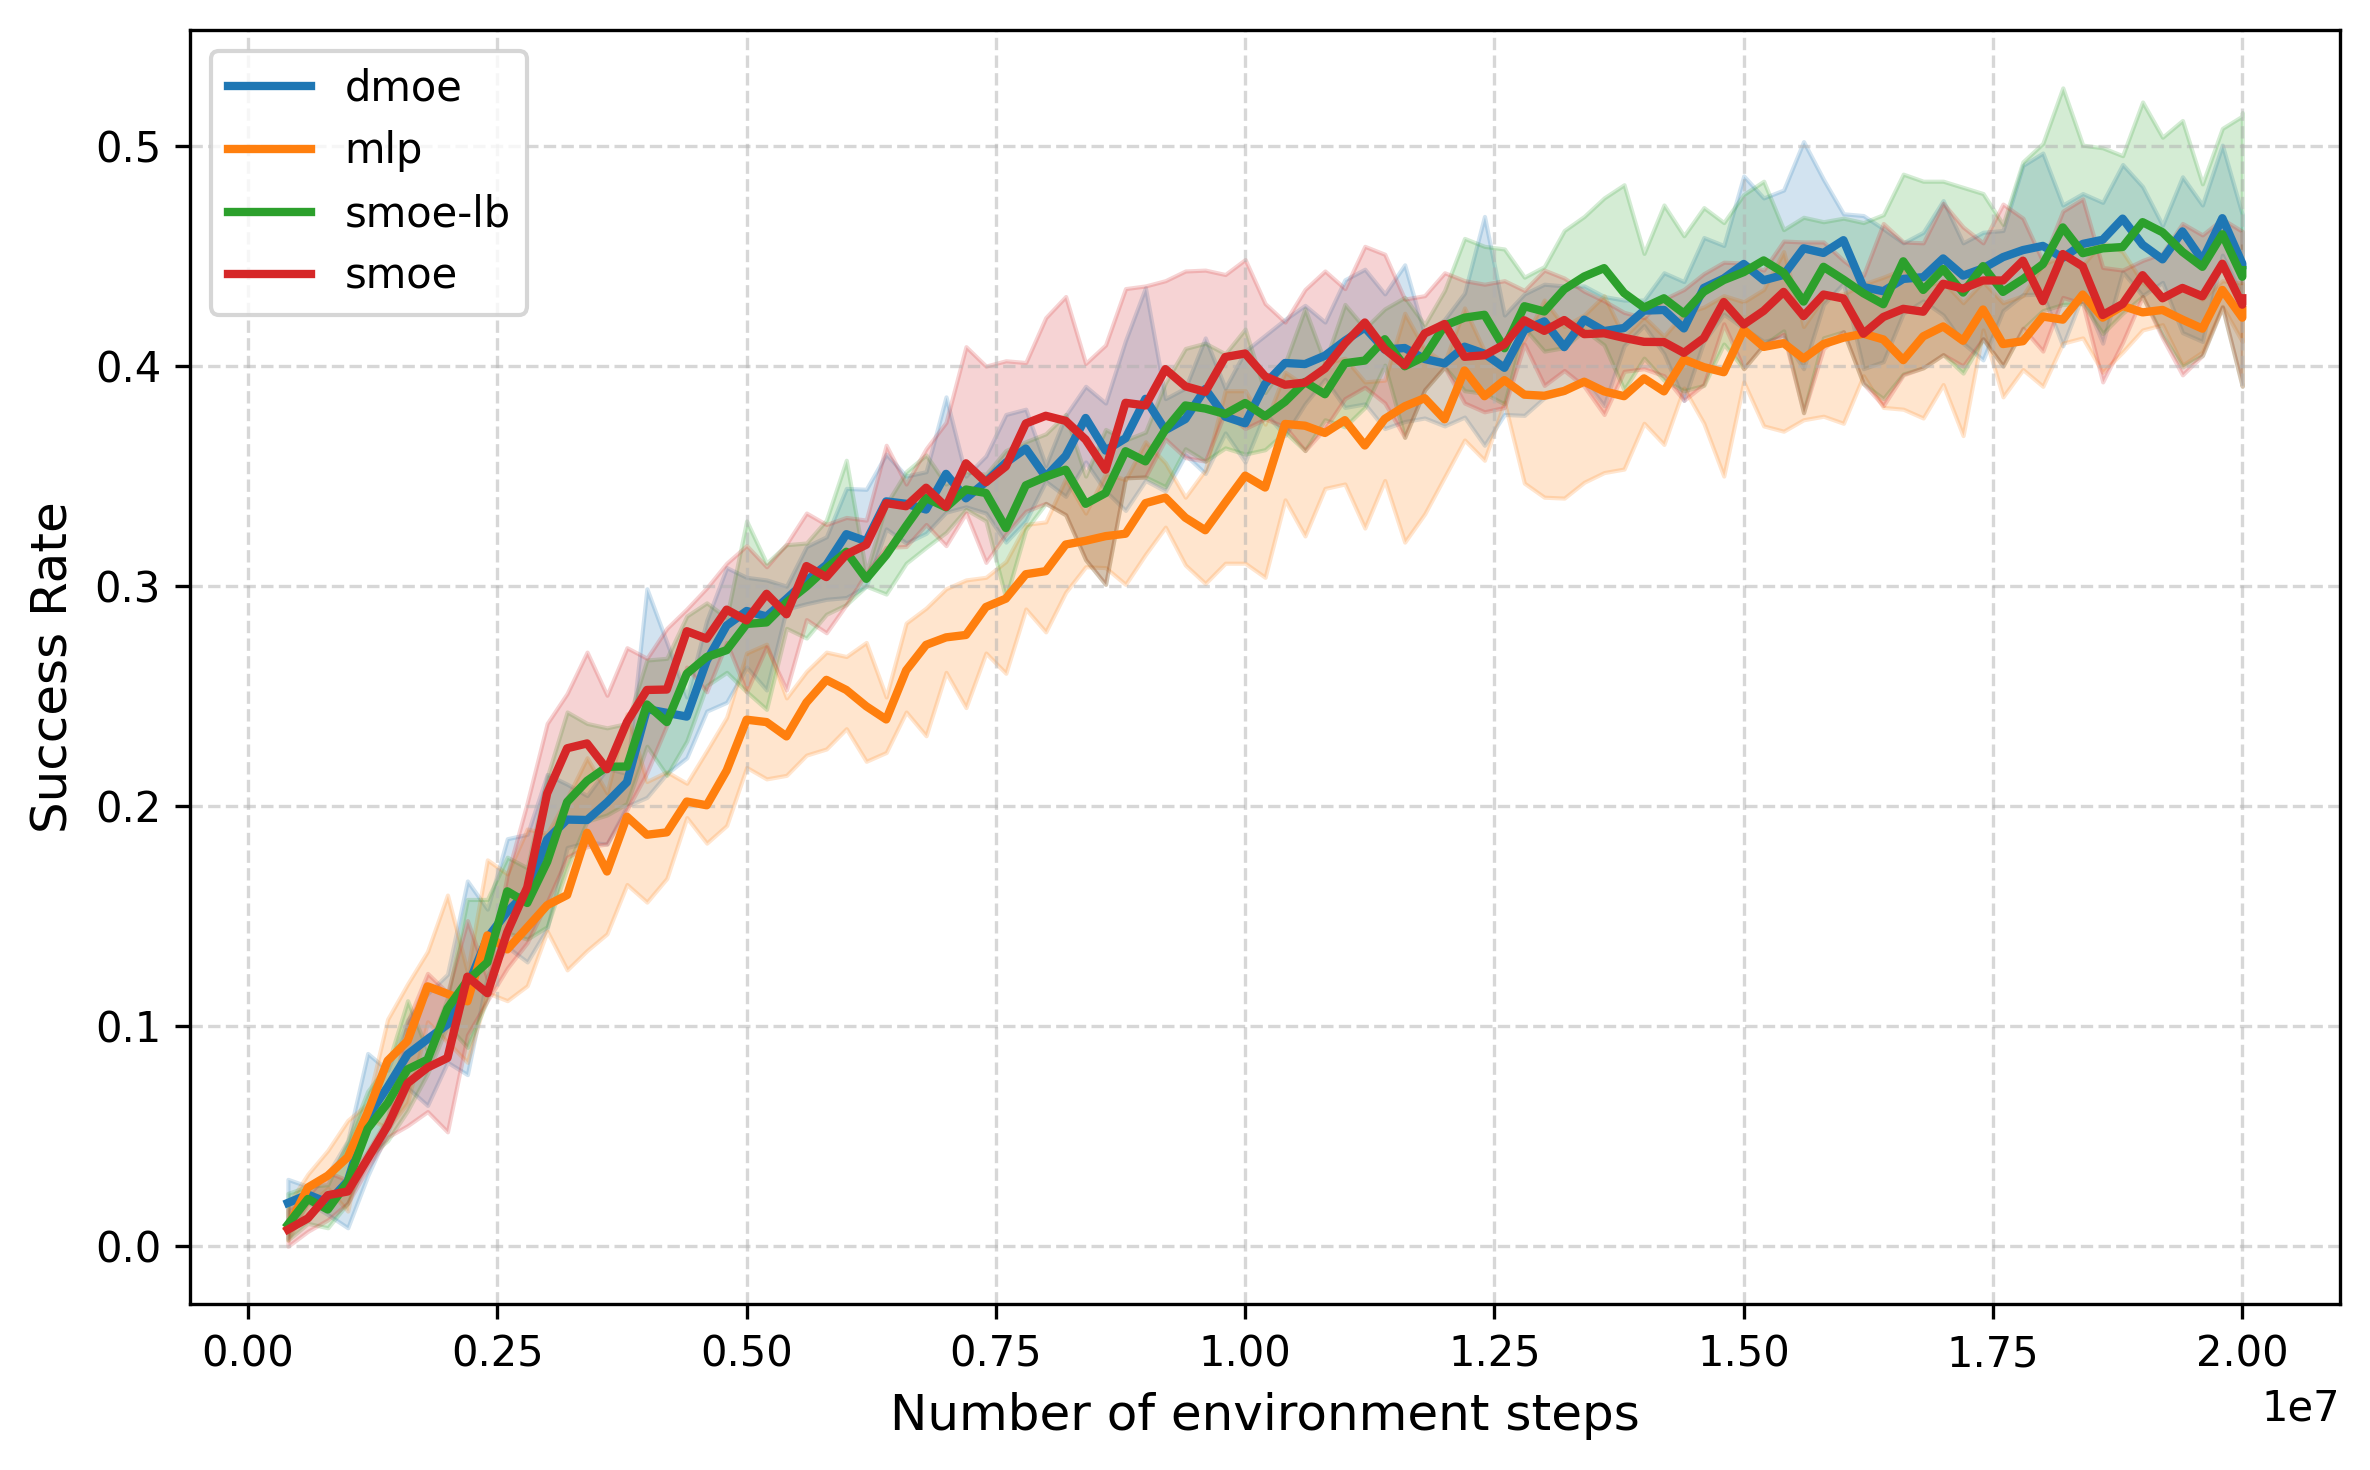

In [28]:
import glob
import os

# Find all wandb_export CSV files (excluding the mean_success_rate summary file)
csv_files = glob.glob("wandb_logs/wandb_export_*.csv")
csv_files = [f for f in csv_files if "mean_success_rate" not in os.path.basename(f)]

# Define colors for each algorithm
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
algorithm_names = []

# Create the plot
fig, ax = plt.subplots(figsize=(8, 5), dpi=300)

for idx, csv_file in enumerate(sorted(csv_files)):
    # Extract algorithm name from filename
    # e.g., "wandb_logs/wandb_export_dmoe.csv" -> "dmoe"
    algorithm_name = os.path.basename(csv_file).replace("wandb_export_", "").replace(".csv", "")
    algorithm_names.append(algorithm_name)
    
    # Read CSV
    df = pd.read_csv(csv_file)
    
    # Find columns ending with mean_success_rate, mean_success_rate__MIN, mean_success_rate__MAX
    mean_col = None
    min_col = None
    max_col = None
    
    for col in df.columns:
        if col.endswith("mean_success_rate") and not col.endswith("__MIN") and not col.endswith("__MAX"):
            mean_col = col
        elif col.endswith("mean_success_rate__MIN"):
            min_col = col
        elif col.endswith("mean_success_rate__MAX"):
            max_col = col
    
    # Find step column
    step_col = None
    for col in df.columns:
        if "step" in col.lower() or col.lower() == "step":
            step_col = col
            break
    
    if step_col is None or mean_col is None or min_col is None or max_col is None:
        print(f"Warning: Could not find all required columns in {csv_file}")
        continue
    
    # Extract data
    steps = pd.to_numeric(df[step_col], errors="coerce")
    mean_vals = pd.to_numeric(df[mean_col], errors="coerce")
    min_vals = pd.to_numeric(df[min_col], errors="coerce")
    max_vals = pd.to_numeric(df[max_col], errors="coerce")
    
    # Remove NaN rows
    valid_mask = ~(steps.isna() | mean_vals.isna() | min_vals.isna() | max_vals.isna())
    steps = steps[valid_mask]
    mean_vals = mean_vals[valid_mask]
    min_vals = min_vals[valid_mask]
    max_vals = max_vals[valid_mask]
    
    # Sort by steps
    sort_idx = steps.argsort()
    steps = steps.iloc[sort_idx]
    mean_vals = mean_vals.iloc[sort_idx]
    min_vals = min_vals.iloc[sort_idx]
    max_vals = max_vals.iloc[sort_idx]
    
    # Plot line
    color = colors[idx % len(colors)]
    ax.plot(steps, mean_vals, label=algorithm_name, color=color, linewidth=2)
    
    # Fill between min and max
    ax.fill_between(steps, min_vals, max_vals, alpha=0.2, color=color)

ax.set_xlabel("Number of environment steps", fontsize=12)
ax.set_ylabel("Success Rate", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('fig/mean_success_rate_comparison.png', dpi=300)
plt.show()


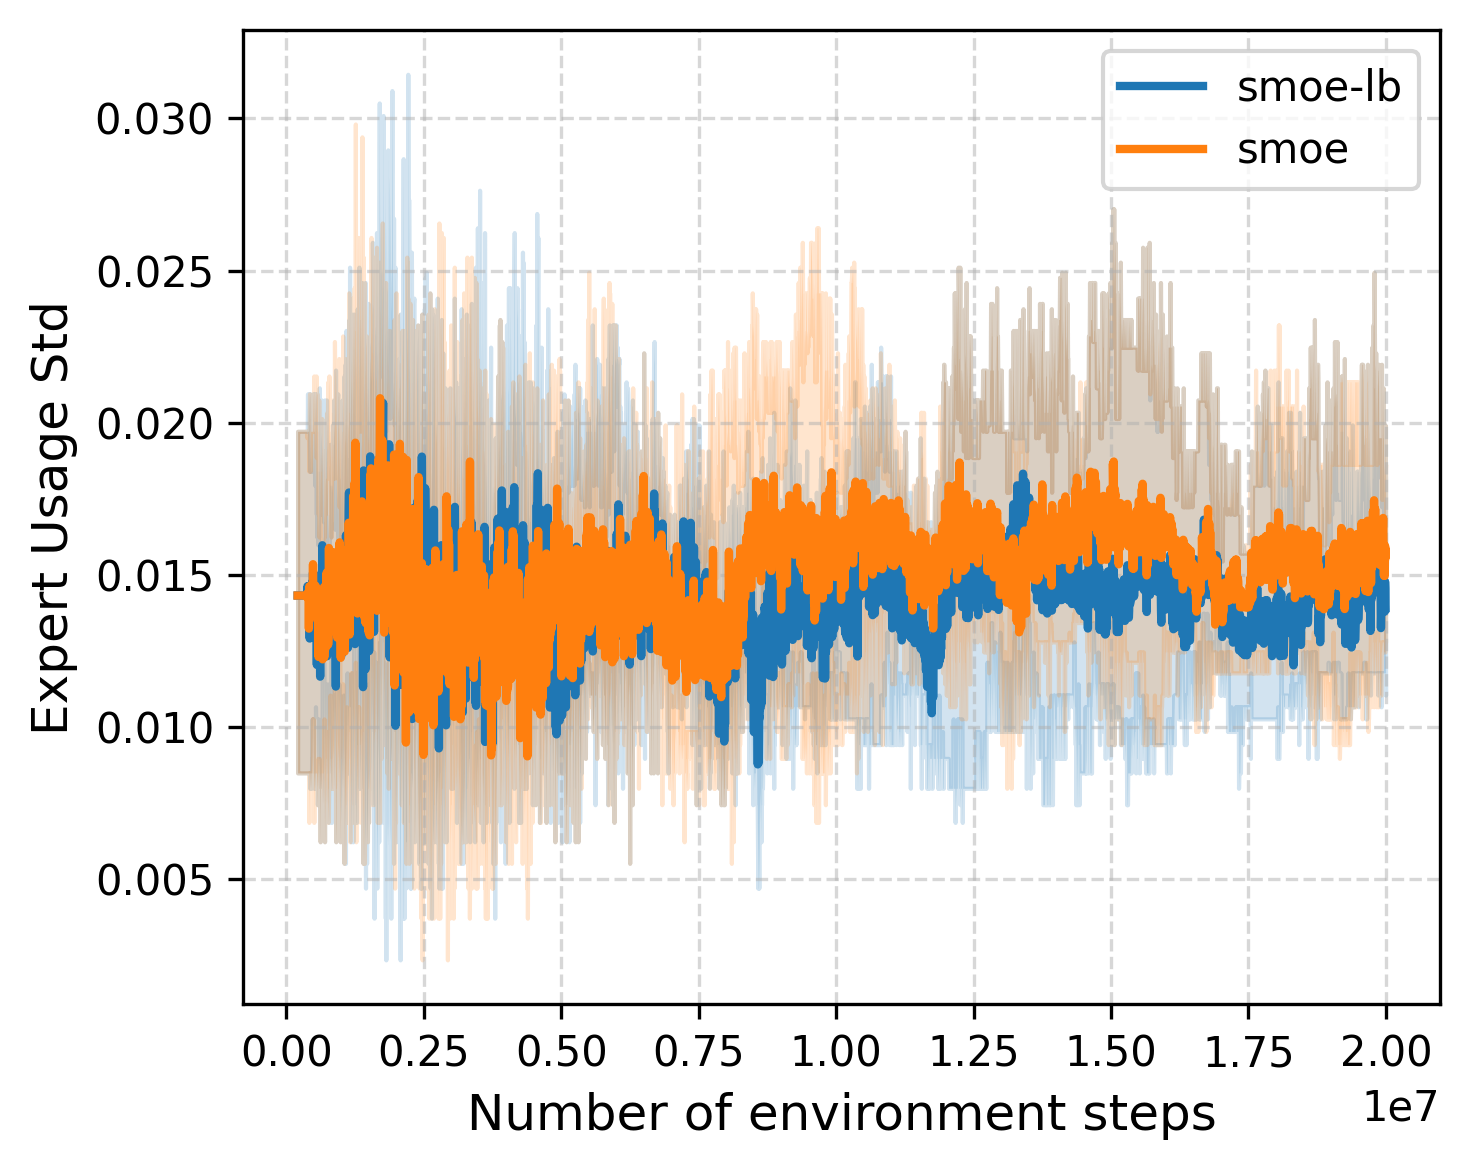

In [35]:
# Find all wandb_export_load CSV files
csv_files = glob.glob("wandb_logs/wandb_export_load_*.csv")

# Define colors for each algorithm
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# Create the plot
fig, ax = plt.subplots(figsize=(5, 4), dpi=300)

for idx, csv_file in enumerate(sorted(csv_files)):
    # Extract algorithm name from filename
    # e.g., "wandb_logs/wandb_export_load_smoe-lb.csv" -> "smoe-lb"
    algorithm_name = os.path.basename(csv_file).replace("wandb_export_load_", "").replace(".csv", "")
    
    # Read CSV
    df = pd.read_csv(csv_file)
    
    # Find columns ending with expert_usage_std, expert_usage_std__MIN, expert_usage_std__MAX
    mean_col = None
    min_col = None
    max_col = None
    
    for col in df.columns:
        if col.endswith("expert_usage_std") and not col.endswith("__MIN") and not col.endswith("__MAX"):
            mean_col = col
        elif col.endswith("expert_usage_std__MIN"):
            min_col = col
        elif col.endswith("expert_usage_std__MAX"):
            max_col = col
    
    # Find step column
    step_col = None
    for col in df.columns:
        if "step" in col.lower() or col.lower() == "step":
            step_col = col
            break
    
    if step_col is None or mean_col is None or min_col is None or max_col is None:
        print(f"Warning: Could not find all required columns in {csv_file}")
        print(f"  Found columns: {df.columns.tolist()}")
        continue
    
    # Extract data
    steps = pd.to_numeric(df[step_col], errors="coerce")
    mean_vals = pd.to_numeric(df[mean_col], errors="coerce")
    min_vals = pd.to_numeric(df[min_col], errors="coerce")
    max_vals = pd.to_numeric(df[max_col], errors="coerce")
    
    # Remove NaN rows
    valid_mask = ~(steps.isna() | mean_vals.isna() | min_vals.isna() | max_vals.isna())
    steps = steps[valid_mask]
    mean_vals = mean_vals[valid_mask]
    min_vals = min_vals[valid_mask]
    max_vals = max_vals[valid_mask]
    
    # Sort by steps
    sort_idx = steps.argsort()
    steps = steps.iloc[sort_idx]
    mean_vals = mean_vals.iloc[sort_idx]
    min_vals = min_vals.iloc[sort_idx]
    max_vals = max_vals.iloc[sort_idx]
    
    # Plot line
    color = colors[idx % len(colors)]
    ax.plot(steps, mean_vals, label=algorithm_name, color=color, linewidth=2)
    
    # Fill between min and max
    ax.fill_between(steps, min_vals, max_vals, alpha=0.2, color=color)

ax.set_xlabel("Number of environment steps", fontsize=12)
ax.set_ylabel("Expert Usage Std", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('fig/expert_usage_std_comparison.png', dpi=300)
plt.show()


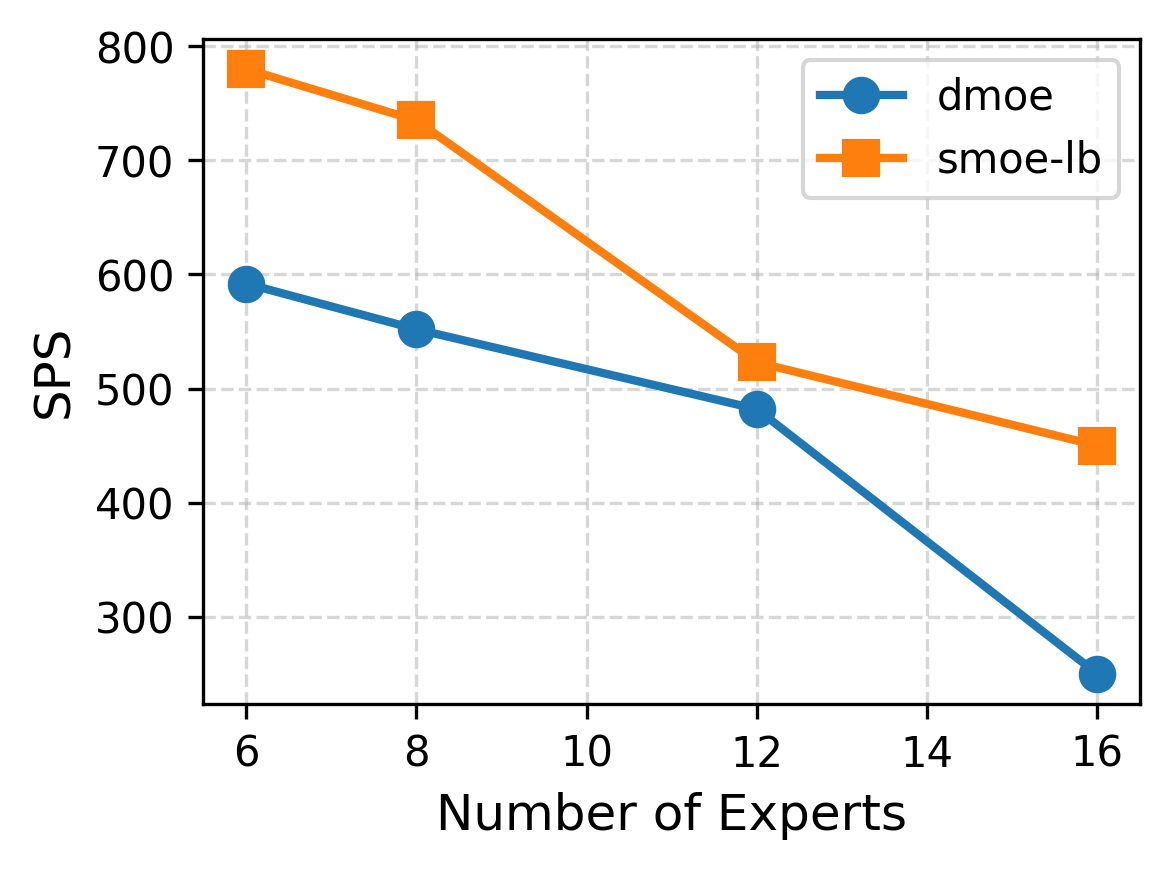

In [34]:
num_experts = [6,8,12,16]
sps_dmoe = [592,552, 482, 250]
sps_smoe = [780, 735, 523, 450]

# Plot SPS vs Number of Experts
fig, ax = plt.subplots(figsize=(4, 3), dpi=300)

ax.plot(num_experts, sps_dmoe, marker='o', label='dmoe', linewidth=2, markersize=8)
ax.plot(num_experts, sps_smoe, marker='s', label='smoe-lb', linewidth=2, markersize=8)

ax.set_xlabel("Number of Experts", fontsize=12)
ax.set_ylabel("SPS", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('fig/sps_vs_num_experts.png', dpi=300)
plt.show()

In [ ]:
num_experts = [6,8,12,16]
success_rate_dmoe = [39.92, 42.84, 44.24, 46.40]
success_rate_smoe = [780, 735, 523, 450]

# Plot SPS vs Number of Experts
fig, ax = plt.subplots(figsize=(4, 3), dpi=300)

ax.plot(num_experts, sps_dmoe, marker='o', label='dmoe', linewidth=2, markersize=8)
ax.plot(num_experts, sps_smoe, marker='s', label='smoe-lb', linewidth=2, markersize=8)

ax.set_xlabel("Number of Experts", fontsize=12)
ax.set_ylabel("SPS", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('fig/sps_vs_num_experts.png', dpi=300)
plt.show()